In [1]:
from sys import path
from os.path import relpath, realpath, abspath, join, exists
from itertools import product

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

pd.set_option('display.max_rows', 999)

In [2]:
from torchnetjson.builder import build_net

In [3]:
from thesis_v2 import dir_dict
from thesis_v2.data import load_data_helper
from thesis_v2.training.training_aux import load_training_results
from thesis_v2.training_extra.misc import count_params
from thesis_v2.models.maskcnn_polished_with_rcnn_k_bl.builder import load_modules

load_modules()

In [4]:
from thesis_v2.configs.model.maskcnn_polished_with_rcnn_k_bl import (
    explored_models_20200208 as param_iterator_obj,
    keygen
)

In [5]:
# compute ccmax
from strflab.stats import cc_max
from thesis_v2.data.prepared.yuanyuan_8k import get_neural_data_per_trial

cc_max_all_neurons = cc_max(get_neural_data_per_trial(
    ('042318', '043018','051018',))
                           )
assert cc_max_all_neurons.shape == (79,)

In [6]:
def load_everything():
    _df_collect = []
    for idx, param in enumerate(param_iterator_obj().generate()):
        if idx % 100 == 0:
            print(idx)
            
#         if idx >= 100:
#             break
            
#         print(len(param))
        
        assert len(param) == 19
        
        assert param['split_seed'] == 'legacy'
        assert param['pooling_ksize'] == 3
        assert param['pooling_type'] == 'avg'
        assert not param['bn_after_fc']
        assert param['rcnn_bl_psize'] == 1
        assert param['rcnn_bl_ptype'] is None
        assert param['input_size'] == 50
        # 12 to go
        # remove smoothness_name and scale_name, 10 to go
        
#         assert param['model_seed'] == 0
        
        key = keygen(**{k: v for k, v in param.items() if k not in {'scale', 'smoothness'}})
        # 10 to go.
        result = load_training_results(key, return_model=False)
        # load twice, first time to get the model.
#         result = load_training_results(key, return_model=True, model=build_net(result['config_extra']['model']))
        num_epochs = [len(x) for x in result['stats_all']]
        
        cc_raw = np.asarray(result['stats_best']['stats']['test']['corr'])
        assert cc_raw.shape == (79,)
        
        _df_collect.append(
            {
                'act_fn': param['act_fn'],
                'loss_type': param['loss_type'],
                'scale': float(param['scale']),
                'smoothness': float(param['smoothness']),
                'num_layer': param['num_layer'],
                'out_channel': param['out_channel'],
                'kernel_size_l1': param['kernel_size_l1'],
                # 4 to go.

                'rcnn_bl_cls': param['rcnn_bl_cls'],
                'rcnn_acc_type': param['rcnn_acc_type'],

                'model_seed': param['model_seed'],
                # done,
                'corr_test': ((cc_raw/cc_max_all_neurons)**2).mean(),
                'max_epoch': max(num_epochs),
#                 'num_param': count_params(result['model']),
            }
        )
    _df =  pd.DataFrame(_df_collect, columns=[
#             'split_seed',
        'act_fn',
        'loss_type', 'scale', 'smoothness', 'num_layer',
        'kernel_size_l1', 'out_channel',

        'rcnn_bl_cls', 'rcnn_acc_type', 'model_seed',

        'corr_test',
#         'num_param',
        'max_epoch',
    ])
#     print(_df)
    _df = _df.set_index([
        'act_fn',
        'loss_type', 'scale', 'smoothness', 'num_layer',
        'kernel_size_l1', 'out_channel',
        'rcnn_bl_cls', 'rcnn_acc_type', 'model_seed',
    ], verify_integrity=True)
    return _df

In [7]:
df = load_everything()

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000


In [8]:
corr_mean = df['corr_test'].unstack('model_seed').mean(axis=1)
corr_std = df['corr_test'].unstack('model_seed').std(axis=1)

In [9]:
corr_mean.unstack('rcnn_bl_cls')

rcnn_bl_cls                                                                                    1  \
act_fn   loss_type scale smoothness num_layer kernel_size_l1 out_channel rcnn_acc_type             
relu     mse       0.01  0.000005   2         7              16          cummean        0.635999   
                                                                         instant        0.635999   
                                                             48          cummean        0.657493   
                                                                         instant        0.656403   
                                              9              16          cummean        0.623429   
                                                                         instant        0.623429   
                                                             48          cummean        0.641707   
                                                                         instant        0.640790   
                                              13             16          cummean        0.600643   
                                                                         instant        0.599279   
                                                             48          cummean        0.615156   
                                                                         instant        0.618492   
                                    3         7              16          cummean        0.626239   
                                                                         instant        0.630375   
                                                             48          cummean        0.661742   
                                                                         instant        0.661106   
                                              9              16          cummean        0.622675   
                                                                         instant        0.625014   
                                                             48          cummean        0.644304   
                                                                         instant        0.644304   
                                              13             16          cummean        0.607852   
                                                                         instant        0.606006   
                                                             48          cummean        0.622476   
                                                                         instant        0.618627   
                         0.005000   2         7              16          cummean        0.439788   
                                                                         instant        0.440008   
                                                             48          cummean        0.470165   
                                                                         instant        0.469985   
                                              9              16          cummean        0.423042   
                                                                         instant        0.417501   
                                                             48          cummean        0.429657   
                                                                         instant        0.430055   
                                              13             16          cummean        0.403771   
                                                                         instant        0.403771   
                                                             48          cummean        0.410301   
                                                                         instant        0.410587   
                                    3         7              16          cummean        0.482668   
                                                                         instant        0.485989   


In [10]:
corr_std.unstack('rcnn_bl_cls')

rcnn_bl_cls                                                                                    1  \
act_fn   loss_type scale smoothness num_layer kernel_size_l1 out_channel rcnn_acc_type             
relu     mse       0.01  0.000005   2         7              16          cummean        0.006403   
                                                                         instant        0.006403   
                                                             48          cummean        0.000923   
                                                                         instant        0.002464   
                                              9              16          cummean        0.007016   
                                                                         instant        0.007016   
                                                             48          cummean        0.004190   
                                                                         instant        0.005486   
                                              13             16          cummean        0.000924   
                                                                         instant        0.001005   
                                                             48          cummean        0.001217   
                                                                         instant        0.005936   
                                    3         7              16          cummean        0.006585   
                                                                         instant        0.000301   
                                                             48          cummean        0.002282   
                                                                         instant        0.005867   
                                              9              16          cummean        0.000282   
                                                                         instant        0.003589   
                                                             48          cummean        0.001259   
                                                                         instant        0.001259   
                                              13             16          cummean        0.005037   
                                                                         instant        0.007238   
                                                             48          cummean        0.002597   
                                                                         instant        0.008040   
                         0.005000   2         7              16          cummean        0.006841   
                                                                         instant        0.006530   
                                                             48          cummean        0.000713   
                                                                         instant        0.000966   
                                              9              16          cummean        0.007634   
                                                                         instant        0.000203   
                                                             48          cummean        0.015881   
                                                                         instant        0.015586   
                                              13             16          cummean        0.001923   
                                                                         instant        0.001923   
                                                             48          cummean        0.001681   
                                                                         instant        0.002086   
                                    3         7              16          cummean        0.006437   
                                                                         instant        0.004191   


In [11]:
# let's try to quickly eliminate bad configs, just like before, by plotting scatter plots.
def scatter(x, y, xlabel, ylabel, title):
    plt.close('all')
    plt.figure(figsize=(6, 5))
    plt.scatter(x, y, s=1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axis('equal')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.plot([0,1],[0,1],linestyle='--')
    plt.title(title)
    plt.show()
    print('y-x mean', (y-x).mean(), 'y-x>0 mean', ((y-x)>0).mean())
    print('y top', y.max(), 'x top', x.max())

In [12]:
# here, I need to check the effective ness of act_fn, bn_before_act, bn_after_fc, loss_type
def check_compare_one_case(series_in, label_to_unstack):
    df_unstacked = series_in.unstack(label_to_unstack)
    assert df_unstacked.shape[1] == 2
    labels = [str(x) for x in df_unstacked.columns.values]
    assert len(labels) == 2
    scatter(df_unstacked.values[:,0], df_unstacked.values[:,1], labels[0], labels[1], label_to_unstack)

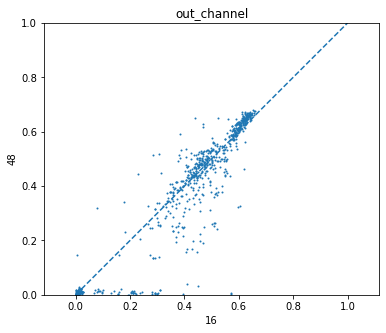

y-x mean -0.015437110726758982 y-x>0 mean 0.55859375
y top 0.6813472272014675 x top 0.6582061412931839


In [13]:
# act_fn, loss_type, scale, smoothness, num_layer, kernel_size_l1, out_channel, rcnn_acc_type
# 16 channels easier to train, fewer failure cases.
check_compare_one_case(corr_mean, 'out_channel')

In [14]:
corr_mean_refine = corr_mean.xs(16, level='out_channel')

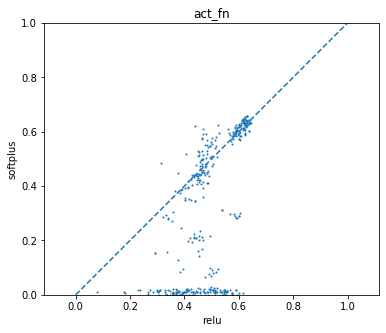

y-x mean -0.17720644036570196 y-x>0 mean 0.296875
y top 0.6582061412931839 x top 0.6452330930588744


In [15]:
# relu better.
check_compare_one_case(corr_mean_refine, 'act_fn')

In [16]:
corr_mean_refine = corr_mean_refine.xs('relu', level='act_fn')

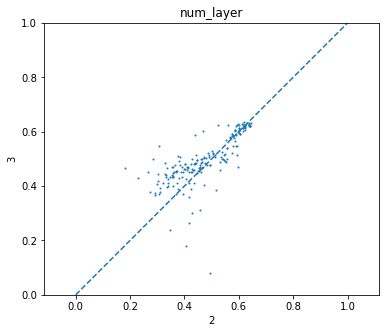

y-x mean 0.023931096181524798 y-x>0 mean 0.6614583333333334
y top 0.6345365361360867 x top 0.6452330930588744


In [17]:
# stick to 2 layers for easier interpretation.
check_compare_one_case(corr_mean_refine, 'num_layer')

In [18]:
corr_mean_refine = corr_mean_refine.xs(2, level='num_layer')

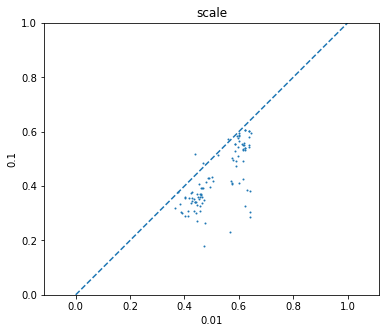

y-x mean -0.09401115991928881 y-x>0 mean 0.041666666666666664
y top 0.6061245077978216 x top 0.6452330930588744


In [19]:
check_compare_one_case(corr_mean_refine, 'scale')
# 0.01 scale is better.


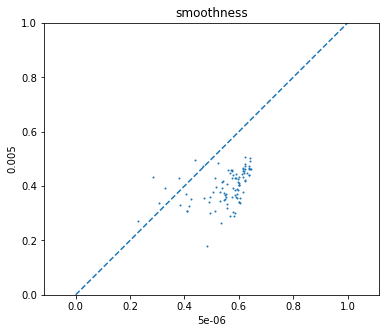

y-x mean -0.15697251440998655 y-x>0 mean 0.07291666666666667
y top 0.5068920859762943 x top 0.6452330930588744


In [20]:
check_compare_one_case(corr_mean_refine, 'smoothness')
# smaller smoothness constraint is better.

In [21]:
corr_mean_refine = corr_mean_refine.xs(5e-6, level='smoothness')

In [22]:
corr_mean_refine = corr_mean_refine.xs(0.01, level='scale')

In [23]:
corr_mean_refine.unstack('rcnn_bl_cls')
# large kernel like 13 is bad.

rcnn_bl_cls                                    1         2         3         4
loss_type kernel_size_l1 rcnn_acc_type                                        
mse       7              cummean        0.635999  0.645233  0.639800  0.640434
                         instant        0.635999  0.636226  0.522133  0.622505
          9              cummean        0.623429  0.559601  0.623131  0.613755
                         instant        0.623429  0.620718  0.616786  0.468861
          13             cummean        0.600643  0.597158  0.590798  0.576113
                         instant        0.599279  0.575573  0.571270  0.567950
poisson   7              cummean        0.601961  0.631706  0.639490  0.637626
                         instant        0.600892  0.611024  0.637260  0.623536
          9              cummean        0.595524  0.613814  0.615781  0.617031
                         instant        0.593551  0.617886  0.623557  0.440359
          13             cummean        0.587768  0.586436  0.591240  0.602584
                         instant        0.587768  0.596707  0.578407  0.576432

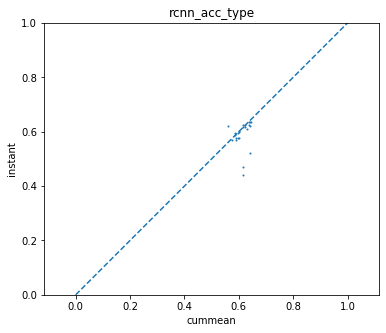

y-x mean -0.021622750980208817 y-x>0 mean 0.16666666666666666
y top 0.6372600067338992 x top 0.6452330930588744


In [24]:
check_compare_one_case(corr_mean_refine, 'rcnn_acc_type')
# cummean is better.